In [1]:
#Welcome to part 2 of make more 

In [2]:
#previously we saw how to implement bigram prediction model i.e given a character, predict next char
#and generate sequence of characters to produce words

#we implement using count method and also using simple neural net grad based learning

#problem with bigram model is, we noticed bigram models output is not that accurate

In [3]:
#if we want to expand wiht more context i.e tri-gram or 4 -gram etc... size of count table explodes exponentially
#for single character - no of rows = 27 ie. 26 alphabets and 1 special char "."

#but for 2 char - rows explode to 27 * 27 rows = 729

#Similarly for 3 grams - 27 * 27 * 27 ~= 20K rows

In [6]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [7]:
from IPython.display import Image
from IPython.display import display

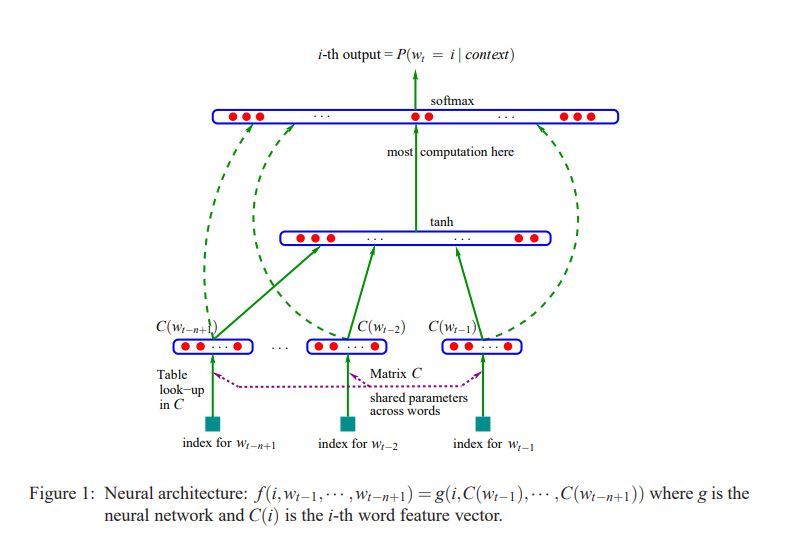

In [8]:
a = Image(r'C:\Users\welcome\Desktop\AndrejKarpathy\net.JPG')
display(a)

In [6]:
#read bengio paper
#https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

#Taking 3 previous words & predicting 4th word in a given sequence
#these words were part of Vocabulary(17K). each words are index from 0 to size of Vocabulary
#We also have lookup vector matrix of size 30 i.e. Size of Vocabulary(17K) * 30 i.e feature vector
#Every word is now embedded into a 30 dim space.
#we pull the corresponding index row from lookup table which represents the vector represent of the word
#so, 30 * 3 = 90 parameters
#then we have hidden layers based on hyperparameter tuning
#output layer with size of Vocabulary predicts prob for each of words in vocab and passed to softmax fn

In [4]:
#Lets try to implement bigram model using Multi Layer Perceptron

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
words = open('names.txt').read().splitlines() #reading text file and split data and store as list

In [10]:
len(words)

32033

In [11]:
words[:8]
#note we have 32k words in vocabulary

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [12]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [13]:
#build the dataset

In [14]:
block_size = 3 #defines no of characters do we take to predict the next one? i.e. context length 
X, Y = [], [] # X are inputs to neural net & y is output

for w in words[:5]: #take 1st 5 words and do it, later change to all words in vocab
    print(w)
    context = [0] * block_size #fist list is [...] 
    for ch in w + '.': #append . at the end of each char to identify end of word
        ix = stoi[ch] #current character
        X.append(context) #current 3 char bigram
        Y.append(ix) #append corresponding output
        print(''.join(itos[i] for i in context), '------>', itos[ix])
        context = context[1:] + [ix] # remove 1st and add new char at end to get next set of 3 gram

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ------> e
..e ------> m
.em ------> m
emm ------> a
mma ------> .
olivia
... ------> o
..o ------> l
.ol ------> i
oli ------> v
liv ------> i
ivi ------> a
via ------> .
ava
... ------> a
..a ------> v
.av ------> a
ava ------> .
isabella
... ------> i
..i ------> s
.is ------> a
isa ------> b
sab ------> e
abe ------> l
bel ------> l
ell ------> a
lla ------> .
sophia
... ------> s
..s ------> o
.so ------> p
sop ------> h
oph ------> i
phi ------> a
hia ------> .


In [15]:
X[1]

tensor([0, 0, 5])

In [16]:
X[1, 2]

tensor(5)

In [17]:
Y[1]

tensor(13)

In [19]:
X.shape, X.dtype, Y.shape, Y.dtype #from the 5 words, we generated 32 examples of trigrams (each with 3 chars)
#label of 32 outputs i.e. next char that follows each trigrams

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [20]:
#from 5 words, we created 32 different 3 char grams  & output of 32 labels i.e. X.shape

In [21]:
#Next we need to build the Embedding K dimensional Vector lookup table/matrix
#in the paper, we had 17000 words into 30 dim lookup table spaces
#for our use case, we convert into 2-dim lookup spaces to start with...

In [22]:
C = torch.randn((27, 2)) # 27 characters, each having 2 dimensional embedding

In [23]:
C[5]

tensor([-0.1186, -0.3126])

In [24]:
C

tensor([[-1.8992, -0.0135],
        [-0.3497,  1.6178],
        [ 0.2679, -1.3872],
        [-0.0742, -1.2637],
        [-0.3452,  0.3516],
        [-0.1186, -0.3126],
        [ 0.6491,  0.8401],
        [ 0.9097,  0.2455],
        [-0.7491,  0.9973],
        [-0.1681, -1.4556],
        [-2.2623,  0.6410],
        [-0.0817, -2.1362],
        [-0.5773,  0.5226],
        [ 0.6488,  0.3221],
        [ 0.6265, -0.1068],
        [-1.3561,  0.6142],
        [ 0.4219, -0.1671],
        [ 1.0042,  1.2017],
        [ 0.0200,  0.1671],
        [-0.4020, -1.1691],
        [-0.1296,  0.6175],
        [ 0.3609, -0.4486],
        [ 0.3157, -0.1707],
        [-0.5129, -0.5381],
        [-0.2020,  0.9439],
        [-0.2695, -0.7355],
        [-0.4806, -0.4511]])

In [25]:
#for each rows of X, we have 2 dim lookup matrix C
#we need to embed all of integers in X using C, but let us take 1 example and see how it works
#lets say we need to embed Row 
C[5] #direct referencing i.e finding embedding feature vector for 5th character from input

tensor([-0.3811, -2.3058])

In [25]:
#alternatively....in previous notes, we used these integers and took 1-hot encoding

In [26]:
F.one_hot(5, num_classes=27)

TypeError: one_hot(): argument 'input' (position 1) must be Tensor, not int

In [27]:
F.one_hot(torch.tensor(5), num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [28]:
F.one_hot(torch.tensor(5), num_classes=27) @ C

RuntimeError: expected scalar type Long but found Float

In [29]:
F.one_hot(torch.tensor(5), num_classes=27).dtype

torch.int64

In [30]:
C.dtype

torch.float32

In [31]:
#note both the data type is different, hence we need to make both in same float datatype

In [32]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C #note using one hot we lookup 5th row from C

tensor([-0.1186, -0.3126])

In [33]:
C[5] #notice how using 1-hot and direct referencing bring same value

tensor([-0.1186, -0.3126])

In [34]:
#So, 2 ways for indexing...we use direct referencing since much faster than one-hot

In [32]:
#embedding a single integer is easy... We can simply refer C[5]
#but input X has shape of 32 rows, 3 columns
#pytorch has powerful indexing methods

In [35]:
#we can index using list
C[[5,6,7]]

tensor([[-0.1186, -0.3126],
        [ 0.6491,  0.8401],
        [ 0.9097,  0.2455]])

In [36]:
C[[5,6,7,7,7,]]

tensor([[-0.1186, -0.3126],
        [ 0.6491,  0.8401],
        [ 0.9097,  0.2455],
        [ 0.9097,  0.2455],
        [ 0.9097,  0.2455]])

In [37]:
C[torch.tensor([5,6,7])] #index can be with tensor

tensor([[-0.1186, -0.3126],
        [ 0.6491,  0.8401],
        [ 0.9097,  0.2455]])

In [38]:
C[torch.tensor([5,6,7,7,7])]

tensor([[-0.1186, -0.3126],
        [ 0.6491,  0.8401],
        [ 0.9097,  0.2455],
        [ 0.9097,  0.2455],
        [ 0.9097,  0.2455]])

In [40]:
#Till now we did 1 dim indexing...

In [41]:
#we can also do multi dim indexing

In [43]:
X.shape

torch.Size([32, 3])

In [44]:
C[X] #since X is 2 dim array of size (32, 3) i.e. 32 different trigrams generated

tensor([[[-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-1.8992, -0.0135]],

        [[-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-0.1186, -0.3126]],

        [[-1.8992, -0.0135],
         [-0.1186, -0.3126],
         [ 0.6488,  0.3221]],

        [[-0.1186, -0.3126],
         [ 0.6488,  0.3221],
         [ 0.6488,  0.3221]],

        [[ 0.6488,  0.3221],
         [ 0.6488,  0.3221],
         [-0.3497,  1.6178]],

        [[-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-1.8992, -0.0135]],

        [[-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-1.3561,  0.6142]],

        [[-1.8992, -0.0135],
         [-1.3561,  0.6142],
         [-0.5773,  0.5226]],

        [[-1.3561,  0.6142],
         [-0.5773,  0.5226],
         [-0.1681, -1.4556]],

        [[-0.5773,  0.5226],
         [-0.1681, -1.4556],
         [ 0.3157, -0.1707]],

        [[-0.1681, -1.4556],
         [ 0.3157, -0.1707],
         [-0.1681, -1.4556]],

        [[ 0.3157, -0

In [45]:
C[X].shape

torch.Size([32, 3, 2])

In [46]:
X[13, 2] #integer 1 as input i.e. char a

tensor(1)

In [47]:
C[X][13, 2]

tensor([-0.3497,  1.6178])

In [48]:
C[1] #see we pulled correct values

tensor([-0.3497,  1.6178])

In [50]:
#Pytorch indexing is awesome and to embded simultaneously all othe inters in X, we can simply do c[x]

In [51]:
emb = C[X] #very simple to reduce input dimension to feature space vector through indexing
emb.shape


torch.Size([32, 3, 2])

In [52]:
print('X[1]:', X[1]) #i.e. ". . e" indexez 0 0 5--> 3 gram
print('C[0]:', C[0]) #randomly generated values for feature space for char a with 0 index
print('C[5]:', C[5]) #randomly generated values for feature space for char e with 5 index
emb[1] # is nothing but one hot pulling of respect X & C rows based on dimension
#understand this how embedding is done....
#note the size of each embed vector of size (3, 2) for each trigram letter, 2 dimensional feature values

X[1]: tensor([0, 0, 5])
C[0]: tensor([-1.8992, -0.0135])
C[5]: tensor([-0.1186, -0.3126])


tensor([[-1.8992, -0.0135],
        [-1.8992, -0.0135],
        [-0.1186, -0.3126]])

In [53]:
#input layer is completed 
#we have take list of words, converted into different 3 grams & its output as next char
# we converted each 3 grams into index
#then we created 2 dim lookup embedding layer and using that we pull respecting lookup embedding by indexing

In [54]:
#Next we construct hidden layer

In [55]:
W1 = torch.randn(6, 100) # since we have 3, 2 dimensional embed vector coming from input layer
#taking 100 as hidden neurons
b1 = torch.randn(100) #bias for each 100 neurons

In [56]:
emb @ W1+b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [57]:
#why emb layer shape is (32, 3, 2) will not match with (6, 100)
#somehow we need to transform to match the shape
#there are many ways, but we go with 'cat' function in pytorch # torch.CAT function

In [58]:
emb[:, 0, :] #fetch all rows, 0th index & all dimensions
#this will fetch 32*2 embedings of just the first char

tensor([[-1.8992, -0.0135],
        [-1.8992, -0.0135],
        [-1.8992, -0.0135],
        [-0.1186, -0.3126],
        [ 0.6488,  0.3221],
        [-1.8992, -0.0135],
        [-1.8992, -0.0135],
        [-1.8992, -0.0135],
        [-1.3561,  0.6142],
        [-0.5773,  0.5226],
        [-0.1681, -1.4556],
        [ 0.3157, -0.1707],
        [-1.8992, -0.0135],
        [-1.8992, -0.0135],
        [-1.8992, -0.0135],
        [-0.3497,  1.6178],
        [-1.8992, -0.0135],
        [-1.8992, -0.0135],
        [-1.8992, -0.0135],
        [-0.1681, -1.4556],
        [-0.4020, -1.1691],
        [-0.3497,  1.6178],
        [ 0.2679, -1.3872],
        [-0.1186, -0.3126],
        [-0.5773,  0.5226],
        [-1.8992, -0.0135],
        [-1.8992, -0.0135],
        [-1.8992, -0.0135],
        [-0.4020, -1.1691],
        [-1.3561,  0.6142],
        [ 0.4219, -0.1671],
        [-0.7491,  0.9973]])

In [59]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1) #concatenate across dimension 1 i.e. column
#basically we are pulling each char embedding seperately and concatnating across dimension

tensor([[-1.8992, -0.0135, -1.8992, -0.0135, -1.8992, -0.0135],
        [-1.8992, -0.0135, -1.8992, -0.0135, -0.1186, -0.3126],
        [-1.8992, -0.0135, -0.1186, -0.3126,  0.6488,  0.3221],
        [-0.1186, -0.3126,  0.6488,  0.3221,  0.6488,  0.3221],
        [ 0.6488,  0.3221,  0.6488,  0.3221, -0.3497,  1.6178],
        [-1.8992, -0.0135, -1.8992, -0.0135, -1.8992, -0.0135],
        [-1.8992, -0.0135, -1.8992, -0.0135, -1.3561,  0.6142],
        [-1.8992, -0.0135, -1.3561,  0.6142, -0.5773,  0.5226],
        [-1.3561,  0.6142, -0.5773,  0.5226, -0.1681, -1.4556],
        [-0.5773,  0.5226, -0.1681, -1.4556,  0.3157, -0.1707],
        [-0.1681, -1.4556,  0.3157, -0.1707, -0.1681, -1.4556],
        [ 0.3157, -0.1707, -0.1681, -1.4556, -0.3497,  1.6178],
        [-1.8992, -0.0135, -1.8992, -0.0135, -1.8992, -0.0135],
        [-1.8992, -0.0135, -1.8992, -0.0135, -0.3497,  1.6178],
        [-1.8992, -0.0135, -0.3497,  1.6178,  0.3157, -0.1707],
        [-0.3497,  1.6178,  0.3157, -0.1

In [60]:
#Now we have shape of 32 * 6 which can be multiplied with 6 * 100
#final output will be 32 *100 

In [61]:
#torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
#above code is not dynamic, since currently trigrams we extracted each char embedded manually
#how abot change block_size = 5 or 7  ??
#we use torch unbind function for this

In [63]:
torch.unbind(emb, 1)

(tensor([[-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-0.1186, -0.3126],
         [ 0.6488,  0.3221],
         [-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-1.3561,  0.6142],
         [-0.5773,  0.5226],
         [-0.1681, -1.4556],
         [ 0.3157, -0.1707],
         [-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-0.3497,  1.6178],
         [-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-0.1681, -1.4556],
         [-0.4020, -1.1691],
         [-0.3497,  1.6178],
         [ 0.2679, -1.3872],
         [-0.1186, -0.3126],
         [-0.5773,  0.5226],
         [-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-0.4020, -1.1691],
         [-1.3561,  0.6142],
         [ 0.4219, -0.1671],
         [-0.7491,  0.9973]]),
 tensor([[-1.8992, -0.0135],
         [-1.8992, -0.0135],
         [-0

In [64]:
torch.cat(torch.unbind(emb, 1), 1)

tensor([[-1.8992, -0.0135, -1.8992, -0.0135, -1.8992, -0.0135],
        [-1.8992, -0.0135, -1.8992, -0.0135, -0.1186, -0.3126],
        [-1.8992, -0.0135, -0.1186, -0.3126,  0.6488,  0.3221],
        [-0.1186, -0.3126,  0.6488,  0.3221,  0.6488,  0.3221],
        [ 0.6488,  0.3221,  0.6488,  0.3221, -0.3497,  1.6178],
        [-1.8992, -0.0135, -1.8992, -0.0135, -1.8992, -0.0135],
        [-1.8992, -0.0135, -1.8992, -0.0135, -1.3561,  0.6142],
        [-1.8992, -0.0135, -1.3561,  0.6142, -0.5773,  0.5226],
        [-1.3561,  0.6142, -0.5773,  0.5226, -0.1681, -1.4556],
        [-0.5773,  0.5226, -0.1681, -1.4556,  0.3157, -0.1707],
        [-0.1681, -1.4556,  0.3157, -0.1707, -0.1681, -1.4556],
        [ 0.3157, -0.1707, -0.1681, -1.4556, -0.3497,  1.6178],
        [-1.8992, -0.0135, -1.8992, -0.0135, -1.8992, -0.0135],
        [-1.8992, -0.0135, -1.8992, -0.0135, -0.3497,  1.6178],
        [-1.8992, -0.0135, -0.3497,  1.6178,  0.3157, -0.1707],
        [-0.3497,  1.6178,  0.3157, -0.1

In [65]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [66]:
#this is exactly as same as previous manually conatenation

In [70]:
#but we can do the same using significantly better and more efficient way...

In [67]:
#we can do the same things n methods

In [71]:
#say, we have
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [72]:
a.shape

torch.Size([18])

In [73]:
#we can re-represent this as different sized n- dim tensors

In [74]:
a.view(9,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [75]:
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [76]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [77]:
#as long as given size matches, it will work
#in torch, calling this view is very efficient because of its speed
#reason for this is every tensor has storage, which is one dimensional

In [78]:
a.storage
#refer: blog.ezyang.com/2019/05/pytorch-internals/

<bound method Tensor.storage of tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])>

In [80]:
#but calling the view, we are manipulating some of attributes of that tensor that dictacte how this
#1-dim sequence is interpreted to be an n-dim tensor

#No memory is being chaged, copied, moved or created when we call the view. The storage is identical.
#only the storage attributes like strides, shapes are manipulated

In [81]:
emb.shape

torch.Size([32, 3, 2])

In [82]:
emb.view(32, 6)

tensor([[-1.8992, -0.0135, -1.8992, -0.0135, -1.8992, -0.0135],
        [-1.8992, -0.0135, -1.8992, -0.0135, -0.1186, -0.3126],
        [-1.8992, -0.0135, -0.1186, -0.3126,  0.6488,  0.3221],
        [-0.1186, -0.3126,  0.6488,  0.3221,  0.6488,  0.3221],
        [ 0.6488,  0.3221,  0.6488,  0.3221, -0.3497,  1.6178],
        [-1.8992, -0.0135, -1.8992, -0.0135, -1.8992, -0.0135],
        [-1.8992, -0.0135, -1.8992, -0.0135, -1.3561,  0.6142],
        [-1.8992, -0.0135, -1.3561,  0.6142, -0.5773,  0.5226],
        [-1.3561,  0.6142, -0.5773,  0.5226, -0.1681, -1.4556],
        [-0.5773,  0.5226, -0.1681, -1.4556,  0.3157, -0.1707],
        [-0.1681, -1.4556,  0.3157, -0.1707, -0.1681, -1.4556],
        [ 0.3157, -0.1707, -0.1681, -1.4556, -0.3497,  1.6178],
        [-1.8992, -0.0135, -1.8992, -0.0135, -1.8992, -0.0135],
        [-1.8992, -0.0135, -1.8992, -0.0135, -0.3497,  1.6178],
        [-1.8992, -0.0135, -0.3497,  1.6178,  0.3157, -0.1707],
        [-0.3497,  1.6178,  0.3157, -0.1

In [83]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)
#notice all values match

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [84]:
#Now we have shape of 32 * 6 which can be multiplied with 6 * 100
#final output will be 32 *100 

h = emb.view(32, 6) @ W1 + b1
h.shape

torch.Size([32, 100])

In [85]:
#make dynamic , since 32 inputs will change when no of inputs change...
#h = emb.view(emb.shape[0], 6) @ W1 + b1   or
h = emb.view(-1, 6) @ W1 + b1 # -1 pytorch will infer the shape and substitute

In [86]:
#applying tanh non-linearity 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [87]:
h

tensor([[-0.9973,  0.9893, -0.9466,  ..., -0.9994,  0.9855,  0.9915],
        [-0.6373,  0.9992, -0.9081,  ..., -0.9839,  0.9978,  0.9869],
        [-0.9973,  0.9986, -0.2069,  ..., -0.5792,  0.6752, -0.5860],
        ...,
        [-0.9999,  0.9295,  0.8615,  ..., -0.9928, -0.9317, -0.9415],
        [ 0.9994, -0.9951,  0.4007,  ..., -0.9199, -0.0727,  0.9911],
        [-0.9999,  0.9997,  0.9710,  ..., -0.8752, -0.7114, -0.6765]])

In [89]:
#these are no's between -1 to +1, because of tanh function

In [90]:
h.shape

torch.Size([32, 100])

In [91]:
#Note: we have to be very careful with adding bias, ensure broadcasting will work when adding
# (32 * 100 ) + 
# (1 * 100) broacasting will aling on the right, create a fake dimension of 1 at left 
# then it will copy vertically for every one of the rows of 32 and do element wise addition

In [92]:
#implementing output layer

In [93]:
W2 = torch.randn(100, 27) #100 neurons from previous hidden layyer & 27 output for each characters
b2 = torch.randn(27) # for each output 27 neurons

In [94]:
logits = h @ W2 + b2

In [95]:
logits.shape

torch.Size([32, 27])

In [96]:
counts = logits.exp()

In [97]:
prob = counts / counts.sum(1, keepdims=True)

In [98]:
prob.shape

torch.Size([32, 27])

In [100]:
prob[0].sum()

tensor(1.)

In [103]:
Y # next char to be predicted
#Now we would like to plug out the prob assigned to the correct char...

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [105]:
prob[torch.arange(32), Y]
#This gives the correct prob assigned by this network with this setting of its weights to the correct char in seq

tensor([1.0822e-01, 1.0512e-01, 1.4817e-02, 5.4474e-03, 1.8950e-11, 4.1712e-04,
        1.5111e-04, 9.2656e-03, 2.3263e-09, 3.8056e-09, 5.1975e-10, 1.9420e-17,
        4.7929e-03, 1.6586e-09, 8.6168e-04, 9.8033e-12, 1.8539e-02, 4.4138e-02,
        2.0597e-07, 2.6992e-17, 1.4821e-02, 3.8796e-13, 3.1520e-08, 2.7536e-01,
        2.2782e-14, 9.5689e-03, 1.2114e-08, 2.5172e-05, 3.8998e-02, 9.0990e-01,
        9.4992e-09, 1.5677e-16])

In [106]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.1259)

In [107]:
#This is the loss we need to minimize to get the network to predict correct char in the seq

In [108]:
##########---------------summarizing all these codes----------------------##################

In [109]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [110]:
sum(p.nelement() for p in parameters)

3481

In [111]:
emb = C[X] # 32, 3, 2
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
logits = h @ W2 + b2 # 32, 27
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [112]:
#instead manuall calculating, use pytorch cross_entropy loss function

In [113]:
F.cross_entropy(logits, Y)

tensor(17.7697)

In [114]:
emb = C[X] # 32, 3, 2
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
logits = h @ W2 + b2 # 32, 27
#counts = logits.exp()
#prob = counts / counts.sum(1, keepdims = True)
#loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

In [115]:
#always go with inbuilt functions, it avoid intermediate tensors and much more efficeint when backpropagating
#exp creates problem when we have larger positive values as shown below
#makes to infinity
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [119]:
#this issue we already saw in micrograd code...

In [120]:
counts

tensor([4.5400e-05, 3.3546e-04, 6.7379e-03, 1.0000e+00])

In [121]:
#how pytorch handles this ?? By offestting

logits = torch.tensor([-5, -3, 0, 5]) - 5 
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])

In [123]:
#notice we found max positive value in logits and we subtracted across all tensor values
#we take max positive values, because only positive values are impacted by exp fn
#These are all handled in pytorch inbuilt functions... always go with it

In [124]:
for p in parameters:
    p.requires_grad = True

In [125]:
for _ in range(1000):
    #forward pass
    emb = C[X] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 + b2 # 32, 27
    loss = F.cross_entropy(logits, Y)
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

0.25614026188850403


In [127]:
#very low loss, may be overfitting... we have only 32 inputs and >3K parameters to train
#also notice loss might not go to 0???
logits.max(1)

torch.return_types.max(
values=tensor([13.3349, 17.7903, 20.6014, 20.6123, 16.7355, 13.3349, 15.9982, 14.1721,
        15.9144, 18.3614, 15.9394, 20.9265, 13.3349, 17.1091, 17.1320, 20.0602,
        13.3349, 16.5894, 15.1017, 17.0582, 18.5859, 15.9669, 10.8740, 10.6870,
        15.5056, 13.3349, 16.1795, 16.9742, 12.7426, 16.2010, 19.0844, 16.0197],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [128]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [129]:
#note the output indcies are very close to Y, but for some cases it will differ..
#why ?
# ... --> e , ... --> o etc....
#model not able to understand what exactly follows next to "..."

In [130]:
#Now lets run for full dataset

In [131]:
block_size = 3 #defines no of characters do we take to predict the next one? i.e. context length 
X, Y = [], [] # X are inputs to neural net & y is output

for w in words: #take 1st 5 words and do it, later change to all words in vocab
    #print(w)
    context = [0] * block_size #fist list is [...] 
    for ch in w + '.': #append . at the end of each char to identify end of word
        ix = stoi[ch] #current character
        X.append(context) #current 3 char bigram
        Y.append(ix) #append corresponding output
        #print(''.join(itos[i] for i in context), '------>', itos[ix])
        context = context[1:] + [ix] # remove 1st and add new char at end to get next set of 3 gram

X = torch.tensor(X)
Y = torch.tensor(Y)

In [132]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [133]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [134]:
sum(p.nelement() for p in parameters)

3481

In [135]:
for p in parameters:
    p.requires_grad = True

In [136]:
for _ in range(10):
    #forward pass
    emb = C[X] # 20k, 3, 2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 + b2 # 32, 27
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.1 * p.grad

19.505226135253906
17.08448600769043
15.776531219482422
14.833340644836426
14.002604484558105
13.253263473510742
12.57991886138916
11.983101844787598
11.47049331665039
11.05185604095459


In [139]:
#notice how is the slowness in execution
#Why ? because each time we forward pass & back propagate the entire vocab
#to avoid this, we go for Mini-Batch
#randomly select some portion of data i.e. mini batch and then only forward/backward and update on that little batch

In [140]:
torch.randint(0, 5, (32,)) # generate a seq of 32 no, within range of 0 - 5

tensor([0, 1, 0, 1, 0, 2, 0, 2, 4, 1, 3, 4, 3, 0, 0, 3, 1, 1, 4, 2, 2, 3, 2, 0,
        2, 1, 4, 0, 2, 3, 2, 0])

In [141]:
X.shape

torch.Size([228146, 3])

In [142]:
X.shape[0]

228146

In [143]:
torch.randint(0, X.shape[0], (32,)) # range should be based on input X, hence replacing

tensor([219845,  12771, 157968,  11000, 169121, 106590,  46011, 153509, 225413,
         51949, 169852, 129700, 186591, 159722, 187526, 103777, 179495,  62714,
        212228,  94951,  15076, 199299,  77188, 206812,  79664, 226812,  15089,
        103940, 120457, 221931, 216878, 176497])

In [144]:
for _ in range(100):
    #mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # we always take random 32 3 grams
    #forward pass
    emb = C[X[ix]] # 32, 3, 2 #only for those 32 trigrams we use embeding 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 + b2 # 32, 27
    loss = F.cross_entropy(logits, Y[ix])
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

2.870103120803833


In [145]:
#notice loss is decreasing much faster

In [146]:
#how to find optimal Learning Rate??

In [147]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [148]:
lri = []
lossi = []
for i in range(1000):
    #mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # we always take random 32 3 grams
    #forward pass
    emb = C[X[ix]] # 32, 3, 2 #only for those 32 trigrams we use embeding 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 + b2 # 32, 27
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[i] 
    for p in parameters:
        p.data += -lr * p.grad
    #tracking stats
    lri.append(lr)
    lossi.append(loss.item())
#print(loss.item())

3.4751017093658447
3.325530529022217
3.2236170768737793
3.6410977840423584
2.734513759613037
2.9485480785369873
3.2749032974243164
3.843616247177124
3.861861228942871
2.632803440093994
3.4933016300201416
2.6338438987731934
4.588751792907715
3.274831771850586
3.075941562652588
3.3219079971313477
3.0959537029266357
3.7266626358032227
3.1275408267974854
2.7875161170959473
3.060213088989258
3.111427068710327
3.439222812652588
3.7770044803619385
2.849499464035034
3.36474347114563
3.2363998889923096
2.794857978820801
3.240063428878784
4.273461818695068
3.547335386276245
2.937185049057007
3.2188968658447266
3.26890230178833
4.43191385269165
3.6480095386505127
3.3078978061676025
4.3024492263793945
3.53190541267395
3.2266454696655273
3.4672224521636963
4.113912105560303
3.755152463912964
3.242544412612915
3.6997079849243164
3.889416217803955
3.251131534576416
3.5884456634521484
3.822967290878296
3.775893449783325
3.4016716480255127
2.753328323364258
3.1713531017303467
3.6511878967285156
4.82482

2.770151376724243
2.896725654602051
2.737738847732544
3.2988507747650146
2.6675190925598145
3.383206367492676
3.649031400680542
3.305875062942505
3.164447069168091
3.158125877380371
2.7616846561431885
3.003023862838745
2.6790387630462646
3.0990633964538574
2.406165599822998
3.001121997833252
3.0476105213165283
2.7855565547943115
3.0616626739501953
3.1328558921813965
2.3250184059143066
3.506638288497925
2.6089847087860107
3.156385660171509
2.6108851432800293
2.3754541873931885
2.801874876022339
3.3414087295532227
3.186811923980713
3.496948480606079
2.907931089401245
3.05411434173584
3.1900649070739746
3.2941596508026123
4.115911483764648
2.3608286380767822
3.9617974758148193
2.2659096717834473
2.759084463119507
3.203522205352783
2.697526216506958
3.2208213806152344
2.6980416774749756
3.3019165992736816
3.079808235168457
2.7737154960632324
3.2433931827545166
3.0752038955688477
2.9436469078063965
3.224555253982544
3.0832133293151855
3.0235862731933594
3.045942544937134
3.6221354007720947


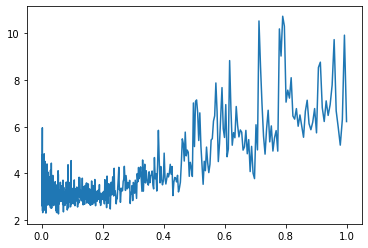

In [149]:
plt.plot(lri, lossi)

In [153]:
#loss is reduced between 0.0 to 0.02 and after step loss is getting increased and going unstable

In [154]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [155]:
lri = []
lossi = []
for i in range(1000):
    #mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # we always take random 32 3 grams
    #forward pass
    emb = C[X[ix]] # 32, 3, 2 #only for those 32 trigrams we use embeding 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 + b2 # 32, 27
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[i] 
    for p in parameters:
        p.data += -lr * p.grad
    #tracking stats
    lri.append(lre[i])
    lossi.append(loss.item())
#print(loss.item())

2.687678575515747
3.013970375061035
3.4932525157928467
2.6724348068237305
2.8499069213867188
2.4565579891204834
3.7067878246307373
3.372262716293335
2.867975950241089
2.889320135116577
3.0507264137268066
3.0506811141967773
2.8358614444732666
3.122316598892212
3.5427122116088867
2.283843994140625
3.1465938091278076
3.001214027404785
2.8851420879364014
2.8323075771331787
2.182180881500244
2.606691598892212
3.2494139671325684
2.636613368988037
2.7601819038391113
3.5075933933258057
2.139404058456421
3.6477866172790527
3.3199448585510254
2.791846990585327
3.3395915031433105
3.0580029487609863
3.555384874343872
3.41332745552063
3.21146297454834
3.088611125946045
3.8562302589416504
3.076460361480713
3.0121238231658936
2.8132829666137695
2.668694496154785
3.248884677886963
3.0180275440216064
2.767829179763794
3.2533442974090576
2.8050830364227295
2.61297345161438
2.587743043899536
3.139751672744751
2.651836633682251
3.1613729000091553
3.307974100112915
2.8148913383483887
2.3486039638519287
2.5

2.7989344596862793
2.4465930461883545
2.645127773284912
2.4152445793151855
2.5316569805145264
2.640580415725708
2.336681365966797
2.3377537727355957
2.846543312072754
2.7215378284454346
2.67244291305542
2.679659843444824
2.9176366329193115
2.6569995880126953
3.526646614074707
2.766731023788452
2.4938864707946777
2.637221336364746
2.435610055923462
3.34702467918396
2.686628818511963
2.353281021118164
3.002450704574585
2.496708631515503
2.7073299884796143
2.897590160369873
2.6355159282684326
3.0549278259277344
3.0510945320129395
3.3568320274353027
2.707476854324341
2.45455265045166
2.699023962020874
2.5553834438323975
2.404189109802246
2.409182548522949
2.8253352642059326
2.8346376419067383
2.866619825363159
2.7863271236419678
3.225449323654175
2.508584976196289
3.0550496578216553
2.86301326751709
2.686008930206299
2.4681379795074463
2.6337156295776367
2.8032279014587402
2.377687931060791
2.7183194160461426
2.639537811279297
3.317962646484375
2.8771886825561523
2.530165195465088
2.202771

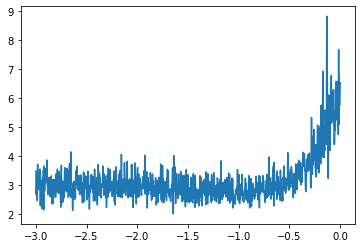

In [156]:
plt.plot(lri, lossi)

In [ ]:
#now in x-axis, we have the exponent of learning rate

In [157]:
#Somewhere aroung -1, the exponent of learning rate is pretty good setting
#10 ^ -1 = 0.01

In [158]:
#from plot we can identify the best learning rate where loss is minimal
#turns out 0.01

In [159]:
for i in range(1000):
    #mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # we always take random 32 3 grams
    #forward pass
    emb = C[X[ix]] # 32, 3, 2 #only for those 32 trigrams we use embeding 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 + b2 # 32, 27
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.01 
    for p in parameters:
        p.data += -lr * p.grad
    #tracking stats
    #lri.append(lr)
    #lossi.append(loss.item())
print(loss.item())

2.238754987716675


In [160]:
#much lower loss when compared with makeover1 basic neural net model

In [161]:
#training with entire model will result in overfiting, model will remember everything instead generalizing
#hence we go for train, test split

In [162]:
#training split, dev/validation split, test split
#80%, 10%, 10%

In [163]:
block_size = 3 #defines no of characters do we take to predict the next one? i.e. context length 
X, Y = [], [] # X are inputs to neural net & y is output

for w in words: #take 1st 5 words and do it, later change to all words in vocab
    #print(w)
    context = [0] * block_size #fist list is [...] 
    for ch in w + '.': #append . at the end of each char to identify end of word
        ix = stoi[ch] #current character
        X.append(context) #current 3 char bigram
        Y.append(ix) #append corresponding output
        #print(''.join(itos[i] for i in context), '------>', itos[ix])
        context = context[1:] + [ix] # remove 1st and add new char at end to get next set of 3 gram

X = torch.tensor(X)
Y = torch.tensor(Y)

In [164]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [165]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words) #random shuffling
n1 = int(0.8*len(words)) 
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80% words in to train dataset
Xdev, Ydev = build_dataset(words[n1:n2]) #10% into validation
Xte, Yte = build_dataset(words[n2:]) #rest 10% for test

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [122]:
#train from train dataset

In [166]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [167]:
sum(p.nelement() for p in parameters)

3481

In [168]:
for p in parameters:
    p.requires_grad = True

In [169]:
for i in range(2000):
    #mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,)) # we always take random 32 3 grams
    #forward pass
    emb = C[Xtr[ix]] # 32, 3, 2 #only for those 32 trigrams we use embeding 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 + b2 # 32, 27
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 
    for p in parameters:
        p.data += -lr * p.grad
    #tracking stats
    #lri.append(lr)
    #lossi.append(loss.item())
print(loss.item())

2.5782833099365234


In [170]:
#trained only from train dataset
#lets evaluate using dev dataset
emb = C[Xdev] # 32, 3, 2
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
logits = h @ W2 + b2 # 32, 27
#counts = logits.exp()
#prob = counts / counts.sum(1, keepdims = True)
#loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.6208, grad_fn=<NllLossBackward0>)

In [171]:
emb = C[Xtr] # 32, 3, 2
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
logits = h @ W2 + b2 # 32, 27
#counts = logits.exp()
#prob = counts / counts.sum(1, keepdims = True)
#loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.6297, grad_fn=<NllLossBackward0>)

In [172]:
#both train & dev loss is almost same, so no overfitting

In [173]:
#lets scale the neural net with multiple hidden layers

In [174]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g) #increased from 100 to 300 hidden neurons
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [175]:
sum(p.nelement() for p in parameters)

10281

In [176]:
for p in parameters:
    p.requires_grad = True

In [177]:
lri = []
lossi = []
stepi = []
for i in range(30000):
    #mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,)) # we always take random 32 3 grams
    #forward pass
    emb = C[Xtr[ix]] # 32, 3, 2 #only for those 32 trigrams we use embeding 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 + b2 # 32, 27
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.05 #little higher learing rate 
    for p in parameters:
        p.data += -lr * p.grad
    #tracking stats
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.item())
print(loss.item())

2.3432188034057617


In [183]:
#loss is lesser than previous, as we increased model size

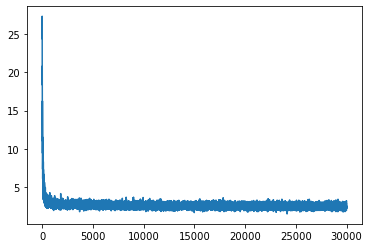

In [178]:
plt.plot(stepi, lossi)

In [179]:
emb = C[Xdev] # 32, 3, 2
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
logits = h @ W2 + b2 # 32, 27
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4512, grad_fn=<NllLossBackward0>)

In [180]:
#try increasing batch size ??

In [181]:
#or
#right now embedding feature vector is just 2 dimension
# may be increasing the featur dim will have much lower loss ??

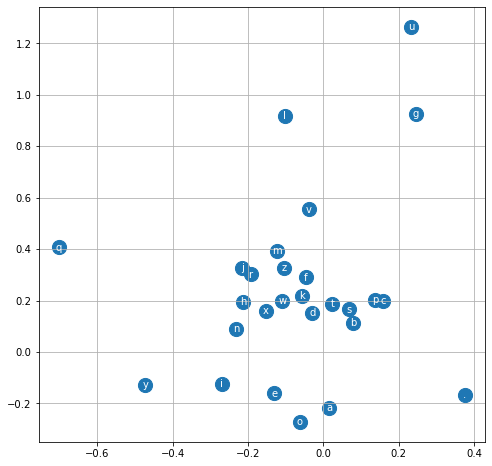

In [182]:
#plotting embeding layer
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [184]:
#network has actually learned to seperate out characters and cluster them a little bit
#a,e,i,o,u are grouped near by... i.e. very similar
#Q is treated as exception
#similary . & u

In [185]:
#Since 2 dim embedding layer, we were able to visualize...
#but if we increase embedding size, then no

In [186]:
#lets change embedding layer size and check if reduction in loss

In [187]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) #10 embedding layer
W1 = torch.randn((30, 200), generator=g) #3 * 10 = 30 parameters & hidden neurons = 200
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [188]:
sum(p.nelement() for p in parameters)

11897

In [189]:
for p in parameters:
    p.requires_grad = True

In [199]:
lri = []
lossi = []
stepi = []

for i in range(50000):
    #mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,)) # we always take random 32 3 grams
    #forward pass
    emb = C[Xtr[ix]] # 32, 3, 2 #only for those 32 trigrams we use embeding 
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #32, 100
    logits = h @ W2 + b2 # 32, 27
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    #tracking stats
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.item())
print(loss.item())

1.978695273399353


In [200]:
emb = C[Xtr] # 32, 3, 2
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #32, 100
logits = h @ W2 + b2 # 32, 27
#counts = logits.exp()
#prob = counts / counts.sum(1, keepdims = True)
#loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3507, grad_fn=<NllLossBackward0>)

In [201]:
emb = C[Xdev] # 32, 3, 2
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #32, 100
logits = h @ W2 + b2 # 32, 27
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3592, grad_fn=<NllLossBackward0>)

In [202]:
#try your best to tweak the hyper parameters and get much lower loss

In [203]:
#Generating samples from the model

In [204]:
g = torch.Generator().manual_seed(2147483647 +10)

for _ in range(20): #generate 20 random words from model
    out = []
    context = [0] * block_size # initialize with 0 
    while True: #till we reach ., continue the loop...
        emb = C[torch.tensor([context])] #embed the current context using current emb vector (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 +b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
ndyn.
alere.
mackejd.
leo.
adered.
elii.
shy.
jean.
keis.
ananar.
kayzimolaia.
noshibmigthimies.
kin.
ren.
jaqubsenofoud.
macdariy.
julieh.


In [205]:
#Thats we generated words using Multi Layer Perceptron implementation

In [206]:
#Though output is not so accurate but much better than previous neural net outputs

In [207]:
#Lot of scope to improve using RNN... Lets see in next session